In [1]:
import pandas as pd
import numpy as np
import tqdm
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
import statsmodels.tsa.api as smt
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
from scipy.stats import boxcox
from math import sqrt
from warnings import filterwarnings
filterwarnings('ignore')
from tqdm import tqdm
from arch import arch_model

In [5]:
data = pd.read_csv('monthly-boston-armed-robberies-j.csv')['Count']

In [6]:
def test_stationarity(timeseries):
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for [key, value] in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

In [7]:
def tsplot(y, lags=None, figsize=(14, 8), style='bmh'):
    test_stationarity(y)
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):
        plt.figure(figsize=figsize)
        layout = (5, 1)
        ts_ax = plt.subplot2grid(layout, (0, 0), rowspan=2)
        acf_ax = plt.subplot2grid(layout, (2, 0))
        pacf_ax = plt.subplot2grid(layout, (3, 0))
        qq_ax = plt.subplot2grid(layout, (4, 0))

        y.plot(ax=ts_ax, color='blue', label='Or')
        ts_ax.set_title('Original')

        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05)
        sm.qqplot(y, line='s', ax=qq_ax)
        
        plt.tight_layout()
    return

Results of Dickey-Fuller Test:
Test Statistic                   1.001102
p-value                          0.994278
#Lags Used                      11.000000
Number of Observations Used    106.000000
Critical Value (1%)             -3.493602
Critical Value (5%)             -2.889217
Critical Value (10%)            -2.581533
dtype: float64


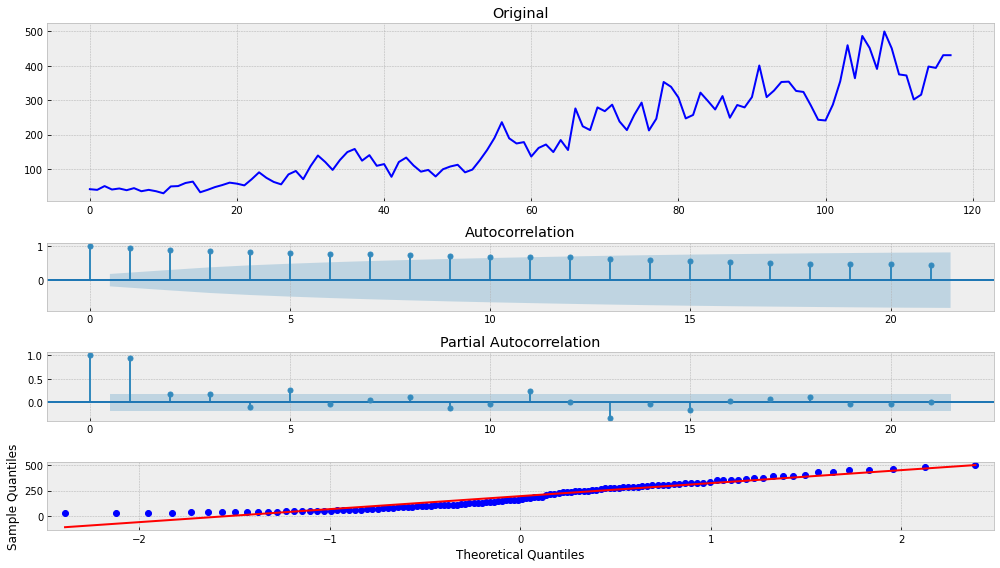

In [8]:
tsplot(data)

Графики корреляционной и частной корреляционной функции позволяют сделать вывод о том, что в ряде присутсвует сезонная компонента (период составляет 12 месяцев). Устраним ее с помощью сезонного дифференцирования.

Приведем ряд к стационарному виду.

In [9]:
data_tr = boxcox(data, 0)
data_tr_seas = data_tr[12:] - data_tr[:-12]
data_tr = data_tr[1:] - data_tr[:-1]

In [10]:
def _get_best_model(TS):
    best_aic = np.inf 
    best_order = None
    best_mdl = None

    for i in tqdm(range(6)):
        for d in range(6):
            for j in range(6):
                try:
                    tmp_mdl = smt.ARIMA(TS, order=(i,d,j)).fit(
                        method='mle', trend='nc'
                    )
                    tmp_aic = tmp_mdl.aic
                    if tmp_aic < best_aic:
                        best_aic = tmp_aic
                        best_order = (i, d, j)
                        best_mdl = tmp_mdl
                except: continue
    print('aic: {:6.5f} | order: {}'.format(best_aic, best_order))                    
    return best_aic, best_order, best_mdl

In [11]:
aic, order, mdl = _get_best_model(data_tr)

100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:47<00:00,  7.90s/it]

aic: -44.47600 | order: (2, 0, 4)


Получены следующие значения:
* p = 2 ;
* d = 0 ;
* q = 4 .  

Величина d=0 является прогнозируемой так как предварительно выполнено дифференцирование временного ряда. Подярок авторегресси равен 2, а порядок скользящего среднего -- 4.

Results of Dickey-Fuller Test:
Test Statistic                -1.122807e+01
p-value                        1.938117e-20
#Lags Used                     0.000000e+00
Number of Observations Used    1.160000e+02
Critical Value (1%)           -3.488022e+00
Critical Value (5%)           -2.886797e+00
Critical Value (10%)          -2.580241e+00
dtype: float64


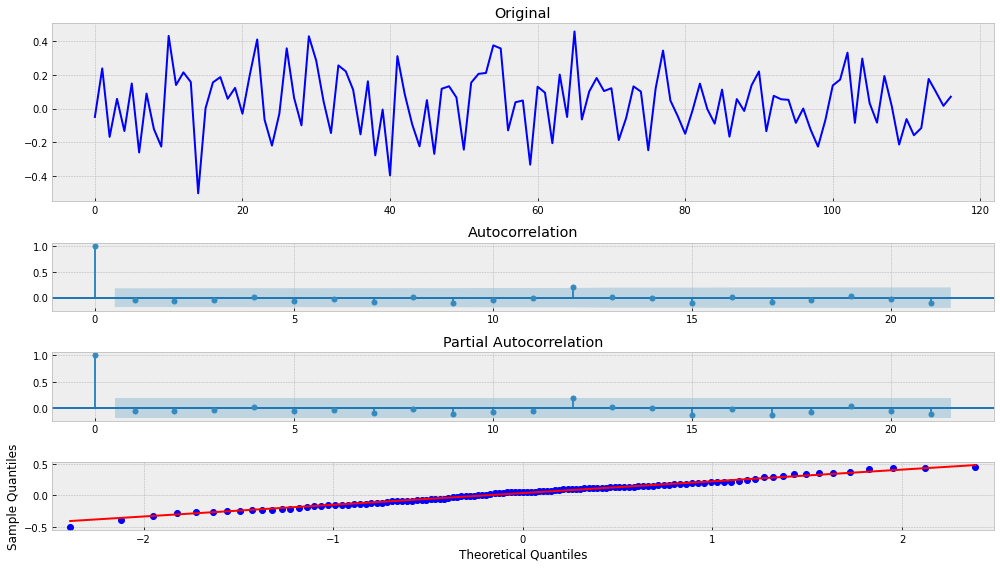

In [12]:
tsplot(mdl.resid)

In [15]:
p = order[0]
o = order[1]
q = order[2]


am = arch_model(data_tr, p=p, o=o, q=q, dist='StudentsT')
res = am.fit(update_freq=5)
print(res.summary())

Iteration:      5,   Func. Count:     62,   Neg. LLF: -19.574462088099807
Iteration:     10,   Func. Count:    118,   Neg. LLF: -19.953183067590437
Iteration:     15,   Func. Count:    173,   Neg. LLF: -20.528361379466144
Iteration:     20,   Func. Count:    228,   Neg. LLF: -20.66644266702571
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -20.666442766717662
            Iterations: 20
            Function evaluations: 239
            Gradient evaluations: 20
                        Constant Mean - GARCH Model Results                         
Dep. Variable:                            y   R-squared:                      -0.000
Mean Model:                   Constant Mean   Adj. R-squared:                 -0.000
Vol Model:                            GARCH   Log-Likelihood:                20.6664
Distribution:      Standardized Student's t   AIC:                          -23.3329
Method:                  Maximum Likelihood   BIC:                 

Results of Dickey-Fuller Test:
Test Statistic                -7.601792e+00
p-value                        2.378602e-11
#Lags Used                     3.000000e+00
Number of Observations Used    1.130000e+02
Critical Value (1%)           -3.489590e+00
Critical Value (5%)           -2.887477e+00
Critical Value (10%)          -2.580604e+00
dtype: float64


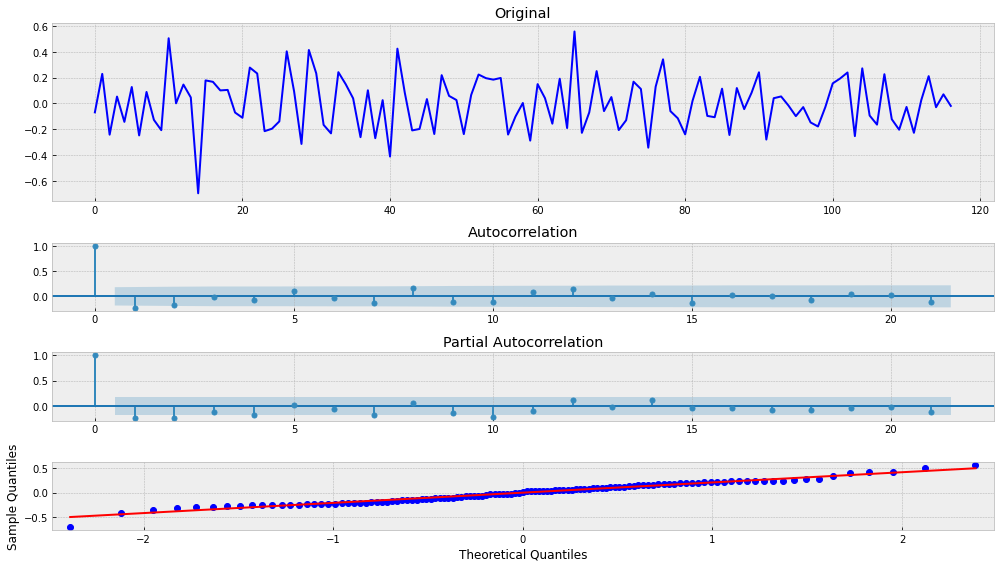

In [16]:
tsplot(res.resid)

Снизились компоненты автокорреляционной и частной корреляцио